### Spatial Understanding with Qwen2.5-VL

This notebook showcases Qwen2.5-VL's advanced spatial localization abilities, including accurate object detection and specific target grounding within images. 

See how it integrates visual and linguistic understanding to interpret complex scenes effectively.

Prepare the environment

#### \[Setup\]

Load visualization utils.

In [2]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
#!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]
API_Key = 'Your Qwen API Key'

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    # img.show()
    plt.imshow(img)
    plt.axis('off')  # optional: hide axes
    plt.show()

def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  #img.show()
  plt.imshow(img)
  plt.axis('off')  # optional: hide axes
  plt.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

Load model and processors.

In [3]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)

/home/tuq24452/anaconda3/envs/Janus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Load inference function.

In [4]:
def inference(img_url, prompt, system_prompt="You are a helpful assistant", max_new_tokens=1024):
  image = Image.open(img_url)
  messages = [
    {
      "role": "system",
      "content": system_prompt
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "image": img_url
        }
      ]
    }
  ]
  text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  print("input:\n",text)
  inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

  output_ids = model.generate(**inputs, max_new_tokens=1024)
  generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
  output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  print("output:\n",output_text[0])

  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14

  return output_text[0], input_height, input_width

inference function with API

In [8]:
from openai import OpenAI
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
# qwen2.5-vl-7b-instruct
# qwen2.5-vl-72b-instruct
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="qwen2.5-vl-7b-instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    client = OpenAI(
        #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        #api_key=os.getenv('DASHSCOPE_API_KEY'),
        api_key = API_Key,
        base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )

    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    
    print('model_id:', model_id)
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

#### 1. Detect certain object in the image

Let's start with a simple scenario where we want to locate certain objects in an image.

Besides, we can further prompt the model to describe their unique characteristics or features by explicitly giving that order.

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Outline the position of each small cake and output all the coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
    {"bbox_2d": [139, 768, 315, 954], "label": "small cake"},
    {"bbox_2d": [366, 679, 536, 849], "label": "small cake"},
    {"bbox_2d": [44, 575, 204, 753], "label": "small cake"},
    {"bbox_2d": [310, 566, 459, 730], "label": "small cake"},
    {"bbox_2d": [533, 579, 689, 738], "label": "small cake"},
    {"bbox_2d": [652, 492, 799, 662], "label": "small cake"},
    {"bbox_2d": [829, 526, 995, 715], "label": "small cake"},
    {"bbox_2d": [765, 393, 895, 552], "label": "small cake"},
    {"bbox_2d": [552, 369, 676, 542], "label": "small cake"},
    {"bbox_2d": [411, 381, 518, 520], "label": "small cake"},
    {"bbox_2d": [262, 393, 384, 557], "label": "small cake"},
    {"bbox_2d": [69, 408, 212, 593], "label": "small ca

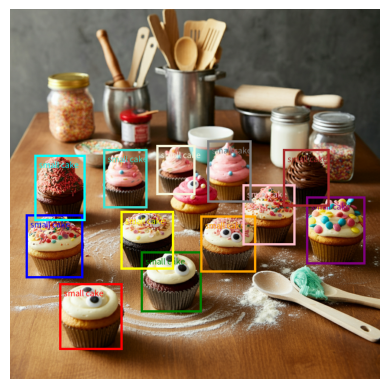

In [6]:
image_path = "./cakes.png"

## Use a local HuggingFace model to inference.
# prompt in english
prompt = "Outline the position of each small cake and output all the coordinates in JSON format."
response, input_height, input_width = inference(image_path, prompt)

image = Image.open(image_path)
print(image.size)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)


model_id: qwen2.5-vl-7b-instruct
(1024, 1024)


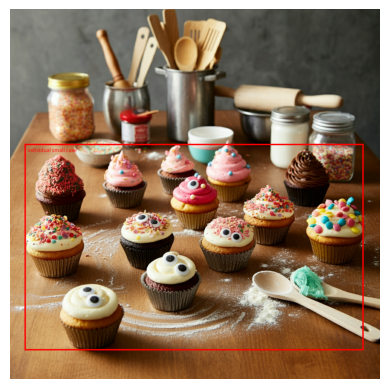

In [10]:
from qwen_vl_utils import smart_resize
prompt =  "Outline the position of individual small cake and output all the coordinates in JSON format."
min_pixels = 512*28*28
max_pixels = 2048*28*28
image = Image.open(image_path)
width, height = image.size
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
response = inference_with_api(image_path, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
plot_bounding_boxes(image, response, input_width, input_height)